In [1]:
from rasterstats import zonal_stats
import rasterio
import pandas as pd
import xarray as xr
import geopandas as gpd
import odc.geo.xr
import os
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rioxarray
from shapely.geometry import mapping

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


# Himawari data

In [ ]:
directory=Path('/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2020/05/05')
# file = [f for f in directory.iterdir()]
files = sorted(str(p) for p in directory.rglob("*.nc"))

ds = xr.open_mfdataset(files, decode_coords='all')

ghi = ds.surface_global_irradiance

ghi.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
ghi.rio.write_crs("EPSG:4326", inplace=True)

# Convert file to .shx

In [4]:
# import geopandas as gpd

# boundary_file_path = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/'
# rez_file_name = 'Indicative REZ boundaries 2024 GIS data.kml'
# # Read the KML file (make sure to specify the correct layer name)
# gdf = gpd.read_file(boundary_file_path + rez_file_name, engine='pyogrio')

# # Save as a shapefile
# gdf.to_file(boundary_file_path + "REZ-boundaries.shx")

# Create mask with rasterio

In [2]:
shapefile = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/REZ-boundaries.shx'
gdf_rez = gpd.read_file(shapefile)
shapefile = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/GCCSA/GCCSA_2021_AUST_GDA2020.shp'
gdf_gccsa = gpd.read_file(shapefile)
shapefile = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/SOS'
gdf_sos = gpd.read_file(shapefile)

### Check crs is EPSG:4326

In [190]:
gdf_gccsa = gdf_gccsa.to_crs(ghi.rio.crs)
gdf_sos = gdf_sos.to_crs(ghi.rio.crs)

In [191]:
gdf_cap = gdf_gccsa[gdf_gccsa['GCC_NAME21'].str.split().str[0] == 'Greater']

In [188]:
gdf_urban = gdf_sos[(gdf_sos['SOS_NAME21'] == 'Major Urban') | (gdf_sos['SOS_NAME21'] == 'Other Urban')]

### Plot mask and masked GHI

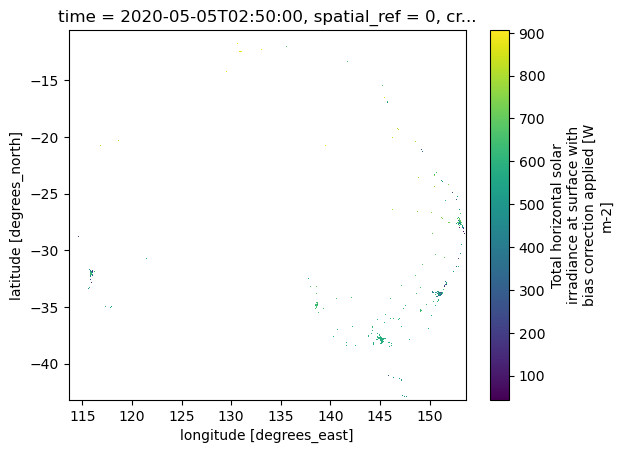

In [193]:
# Using rioxarray
ghi_clipped = ghi.isel(time=50).rio.clip(
    gdf_urban.geometry.apply(mapping),  # Convert to GeoJSON format
    gdf_urban.crs,
    drop=True  # Drops data outside polygons
)

ghi_clipped.plot()

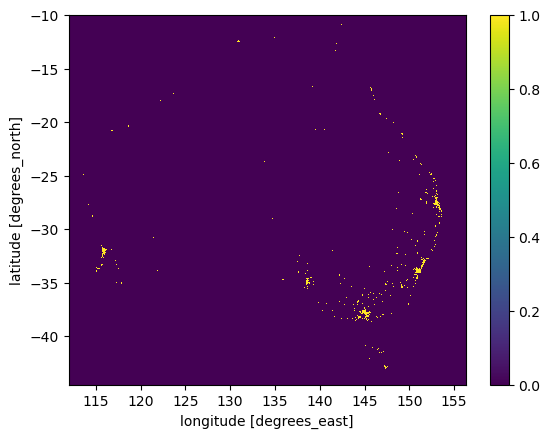

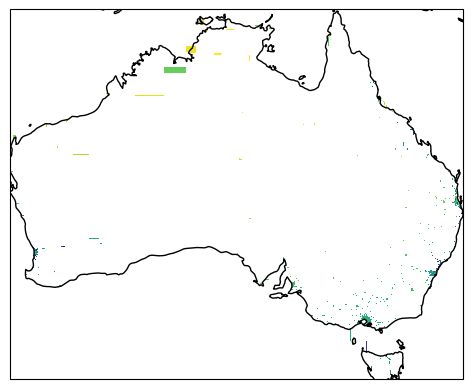

In [178]:
mask = rasterio.features.geometry_mask(
            gdf_urban.geometry,
            out_shape=ghi.isel(time=1).odc.geobox.shape,
            transform=ghi.isel(time=1).odc.geobox.affine,
            all_touched=True,
            invert=False)

mask_ds = xr.DataArray(mask, dims=('latitude', 'longitude'),coords=dict(
        longitude=ghi.longitude,
        latitude=ghi.latitude))

(~mask_ds).plot()

mask_aligned = mask_ds.reindex_like(ghi, method="nearest")
ghi_region = ghi.isel(time=50).where(~mask_aligned, drop=True)

lon = ghi_region.longitude.values
lat = ghi_region.latitude.values

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(lon,
                   lat,
                   ghi_region,
                   cmap='viridis',
                   transform=ccrs.PlateCarree()
                  )

ax.coastlines()

In [43]:
print(gdf_urban.crs)
print(ghi.odc.geobox.crs)  # should be CRS('EPSG:4326')

EPSG:4326
None


# Apply function to mask

In [ ]:
# first define a new statistic as a function
def new_stat(array):
    """This is meaningless just to prove you can add your own calculation"""
    out = array.min() + array.max()
    return out

In [ ]:
# then we test it on 1 timestep
with rasterio.open(f'netcdf:{file}:surface_global_irradiance') as src:
    affine = src.transform
    array = src.read(1)
    newstats = pd.DataFrame(zonal_stats(shapefile, array, 
        affine=affine, stats='mean', add_stats={'mysum': new_stat}))
newstats

# Using Dask for multiple files

In [ ]:
from dask.distributed import Client
ncpus = os.environ.get('PBS_NCPUS')
c = Client(n_workers=int(ncpus))
c

In [ ]:
files = list(directory.glob("*.nc"))

ds = xr.open_mfdataset(files, parallel=True, chunks={'time': '200MB'})
ghi = ds.surface_global_irradiance
ghi

This can be slow, so pre-selecting smaller area can be more efficient

Get region boundaries from shapefile

In [ ]:
lon_min, lat_min, lon_max, lat_max = gdf.total_bounds
gdf.total_bounds

Define a function to select a region based on boundaries

In [ ]:
def select_region(ds):
    ds = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    return ds

Open file using preprocess to select region of interest

In [ ]:
%%time
ds = xr.open_mfdataset(files, parallel=True, preprocess=select_region)
ghi = ds.surface_global_irradiance.chunk({'time': '200MB'})
ghi